# Проект: "Поиск по изображениям"

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. 

## Цель:

Разработка поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.

Для демонстрационной версии нужно выбрать лучшую модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 

## Юридические ограничения

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

### Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## План работы

В текущей формулировке задачи вижу два пути решения.

**Первый путь.** Строим большую выборку оценок на основе оценок комьюнити и экспертов, далее векторизуем описания и изображения, конкатенируем пары векторов, это становится нашим признаком, ему в соответствие ставится сводная оценка. На этих данных обучаем модель. *Что смущает*: в дальнейшем, для того, чтобы определить, какое изображение лучше подходит к запросу, через модель придётся прогнать вектора ВСЕХ имеющихся изображений (модель на вход требует описание+изображение)

**Второй путь.** Строим преобразование вектора описания в вектор изображения (в простейшем случае линейное на линейной регрессии). В этом случае экспертные оценки нам нужны только для того, чтобы отбросить недостоверные пары описание-фото. После обучения модели нам останется только подать на вход вектор запроса и получить вектор изображения. (Интересно было бы попытаться решить обратную задачу и заставить ResNet по имеющемуся вектору восстановить изображение, подозреваю, получится редкостный бред.) Далее наша задача просто найти в базе вектора, максимально близкие полученному. Это и будут искомые изображения. *Что смущает*: не понятны критерии качества обучения. В процессе обучения мы получим вектор "изображения" и можем сравнить его с вектором правильного изображения, получим между ними некоторое расстояние. Как понять, что расстояние достаточно мало или недопустимо велико? Какие использовать метрики? Пока не понятно.  

In [1]:
import pickle
import re
from collections import Counter
from os.path import exists, isfile, join

import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from ipywidgets import IntProgress
from matplotlib import pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.applications.resnet import (
    ResNet50,
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm, trange

2022-09-20 13:21:30.235490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 13:21:30.699662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 13:21:30.699697: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-20 13:21:30.745944: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 13:21:31.789974: W tensorflow/stream_executor/platform/de

Для получения повторяемых результатов, зафиксируем состояния герераторов случайных чисел

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Загрузка и исследовательский анализ данных

In [3]:
if exists("./data"):
    data_path = "./data"
else:
    data_path = "/datasets/image_search/"

In [4]:
train_path = join(data_path, "train_images")
test_path = join(data_path, "test_images")

In [5]:
train_dataset = pd.read_csv(join(data_path, "train_dataset.csv"))

In [6]:
train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [7]:
train_dataset.describe()

image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

Видно, что тренировочном множестве у нас 1000 изображений, имеющих 5822 связей с описаниями, 977 из которых уникальны. 

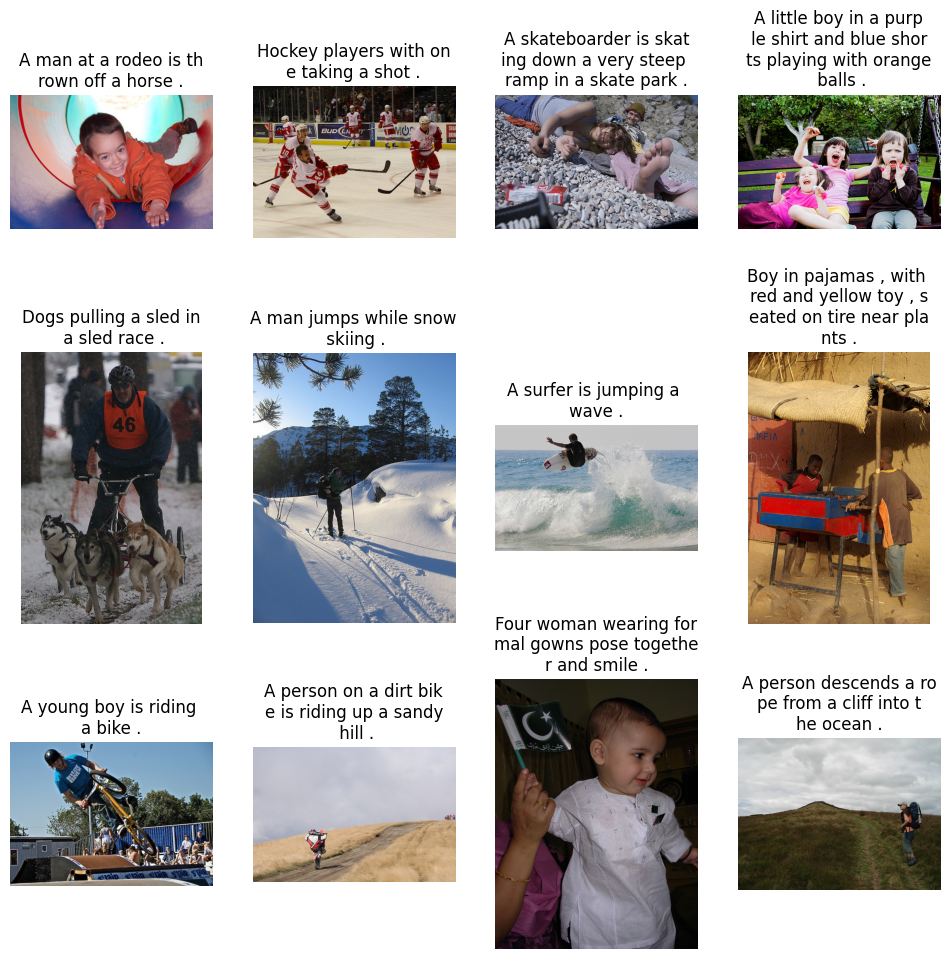

In [8]:
rows = 3
columns = 4

fig = plt.figure(figsize=(12, 12))
count = 1
for _, file, _, query_text in train_dataset.sample(rows * columns).itertuples():
    img = Image.open(join(train_path, file))
    fig.add_subplot(rows, columns, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis("off")
    # title = query_text
    chunks, chunk_size = len(query_text), 22
    plt.title(
        "\n".join(
            [query_text[i : i + chunk_size] for i in range(0, chunks, chunk_size)]
        )
    );

Для дальнейшей работы на будет удобнее переименовать столбец query_id

In [9]:
train_dataset = train_dataset.rename(columns={"query_id": "annotation_id"})

Читаем экспертные оценки точности анотирования фото

In [10]:
expert_annotations = pd.read_csv(
    join(data_path, "ExpertAnnotations.tsv"), sep="\t", header=None
)

In [11]:
expert_annotations.columns = ["image", "annotation_id", "score_1", "score_2", "score_3"]

In [12]:
expert_annotations.head()

image                annotation_id  score_1  score_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   score_3  
0        1  
1        2  
2        2  
3        2  
4        2

In [13]:
expert_annotations.describe()

score_1      score_2      score_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

Видно, что эксперты не высокого мнения о качестве разметки: медиана у двух экспертов из 3 равна 1, т.е. эксперты считают, что половина изображений и их описаний совершенно не соответствуют друг другу. И лишь один эксперт считает, что в половине случаев запрос содержит элементы описания изображения, но в целом фото тексту не соответствует.

Теперь читаем наборы тестовых данных

In [14]:
test_queries = pd.read_csv(join(data_path, "test_queries.csv"), sep="|", index_col=0)

In [15]:
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [16]:
test_queries.describe()

query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

В тестовой выборке 100 фото, которым соответсвует 500 уникальных описаний. Т.е. каждой фотографии соответствует в точности 5 уникальных описаний. 

In [17]:
test_images = pd.read_csv("./data/test_images.csv")

In [18]:
test_images.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [19]:
test_images.describe()

image
count                         100
unique                        100
top     3356748019_2251399314.jpg
freq                            1

### Вывод

В рамках проекта мы загрузили 
1. Тренировочный датасет из 5822 пар изображение-описание
1. Набор оценок экспертов, которые определяли соответствие описания изображдению, это те же 5822 записи фото-описание

Также, был загружен набор тестовых запросов и изображений, на которых предстоит проверить качество работы обученных моделей.

## Подготовка данных

Прежде всего, наша задача распадается на две: 
1. нам нужно на основе описаний в тренировочном датасете и оценок экспертов выявить неприемлемый контент и удалить его из обучающей выборки;
1. Также нужно убрать пары описание-фото, которые не соответствуют друг другу, чтобы не обучать модель на заведоми неправильных сочетаниях
2. на оставшейся выборке обучить модель, которая будет сопоставлять изображения заданным описаниям.

### Построение сводной экспертной оценки

Эксперта 3, но оценка нужна одна, поэтому используем метод голосования: если 2 эксперта поставили одинаковую оценку, она считается верной. если все три оценки разные, такое описание отбрасывается.

In [20]:
def voting(v1, v2, v3):
    """функция принимает тройку оценок и возвращает ту, что совпадает хотя бы у двоих, иначе возвращает None"""
    if v1 == v2 or v1 == v3:
        return v1
    elif v2 == v3:
        return v2
    else:
        return None

In [21]:
expert_annotations["experts"] = expert_annotations.apply(
    lambda x: voting(x["score_1"], x["score_2"], x["score_3"]), axis=1
)

Удаляем несогласованные оценки

In [22]:
expert_annotations.dropna(subset=["experts"], inplace=True)

Масштабируем сводную оценку:

In [23]:
mm_scaler = MinMaxScaler()

In [24]:
expert_annotations["experts"] = mm_scaler.fit_transform(expert_annotations[["experts"]])

Поскольку нас интересуют только более-менее соответствующие друг другу изображения и описания, отбросим сочетания, для которым экспертная оценка ниже 0,5 

In [25]:
expert_annotations = expert_annotations.drop(
    expert_annotations[expert_annotations["experts"] < 0.5].index, axis=0
)

In [26]:
expert_annotations.shape

(803, 6)

Получается, правильных описаний к фото у нас всего 803. Не густо. Можно попробовать снизить планку точности оценок, но это чревато ошибками сопоставления.

Наложим полученные экспертные оценки на тренировочный датасет

In [27]:
train_dataset = (
    train_dataset.set_index(["image", "annotation_id"])
    .join(
        expert_annotations.set_index(["image", "annotation_id"])[["experts"]],
        how="inner",
    )
    .reset_index()
)

### Лемматизация описаний

Для начала лемматизируем описания фотографий. Потом применим к леммам векторайзер 

In [28]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /home/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /home/sam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/sam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
lemmatizer = WordNetLemmatizer()

Для дальнейшей работы тексты нужно лемматизировать и токенизировать. В ряде случаев для правильной лемматизации лемматезатору требуется уточнение, какой частью речи является слова (POS). Эту информацию также можно получить средствами nltk 

In [31]:
def pos_tag(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }
    # если слово не является существительным, прилагательным, гаголом или наречием, назначаем его существительным
    return tag_dict.get(tag, wordnet.NOUN)

In [32]:
%%time
train_dataset["lemm_query"] = train_dataset["query_text"].apply(
    lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]
    )
)

CPU times: user 1.48 s, sys: 105 ms, total: 1.59 s
Wall time: 1.58 s


In [33]:
train_dataset["lemm_query"] = train_dataset["lemm_query"].apply(
    lambda x: (" ".join(re.sub(r"[^a-zA-Z ]", " ", x).split()).lower())
)

### Удаление проблемного контента

Прежде всего, составим список слов, используемых в английском для обозначения детей и подростков и напишем функцию, которая будет искать эти слова в лемматезированных текстах

In [34]:
child_stop = [
    "boy",
    "young",
    # "girl",
    "child",
    "baby",
    "kid",
    "babe",
    "infant",
    "teenager",
    "teeny",
    "juvenile",
    "teener",
    "stripling",
]

In [35]:
def child_in_text(text: str) -> bool:
    """Последовательно ищем слова из стоп-листа child_stop в заданном тексте text. Возвращаем True, если нашлось хотя бы одно слово"""
    res = False
    for w in child_stop:
        res |= text.lower().find(w) > -1
    return res

In [36]:
train_dataset["child"] = train_dataset.apply(
    lambda x: child_in_text(x["lemm_query"]), axis=1
)

Удаляем найденные изображения с детьми. Для этого сначала составляем список изображений, где обнаружены дети, потом удаляем все записи, содержащие эти изображения.

In [37]:
child_images = set(train_dataset[train_dataset["child"] == True]["image"])

In [38]:
train_dataset = train_dataset.drop(
    train_dataset[train_dataset["image"].isin(child_images)].index, axis=0
)

In [39]:
train_dataset.shape

(653, 6)

У нас осталось всего 646 описания

### Разбиение тренировочного множества на тренировочную и валидационную выборки

Прежде чем векторизовать набор описаний, отделим валидационную выборку: её не следует использовать при ембеддинге. 

Поскольку у нас одному изображению соответствует несколько описаний, наивное случайное разделение может привести к тому, что одно и тоже фото может оказаться и в тестовой и валидационой, что недопустимо

In [40]:
train_dataset.head()

image                annotation_id  \
2    700884207_d3ec546494.jpg  2718495608_d8533e3ac5.jpg#2   
5   1425069308_488e5fcf9d.jpg  1425069308_488e5fcf9d.jpg#2   
8   1897025969_0c41688fa6.jpg  2398605966_1d0c9e6a20.jpg#2   
9   2340206885_58754a799a.jpg  2398605966_1d0c9e6a20.jpg#2   
10   317383917_d8bfa350b6.jpg  2398605966_1d0c9e6a20.jpg#2   

                                           query_text   experts  \
2   A girl wearing a yellow shirt and sunglasses s...  0.666667   
5   A white dog jumps to catch a blue ball in a li...  1.000000   
8   Two long-haired puppy dogs have a romp in the ...  0.666667   
9   Two long-haired puppy dogs have a romp in the ...  0.666667   
10  Two long-haired puppy dogs have a romp in the ...  0.666667   

                                           lemm_query  child  
2       a girl wear a yellow shirt and sunglass smile  False  
5   a white dog jump to catch a blue ball in a liv...  False  
8   two long haired puppy dog have a romp in the snow  False  
9   two long haired puppy dog have a romp in the snow  False  
10  two long haired puppy dog have a romp in the snow  False

In [41]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=42)
train_indices, test_indices = next(
    gss.split(
        X=train_dataset.drop(columns=["annotation_id"]),
        y=train_dataset["annotation_id"],
        groups=train_dataset["image"],
    )
)
train_df, test_df = train_dataset.iloc[train_indices], train_dataset.iloc[test_indices]

In [42]:
train_df.head()

image                annotation_id  \
5   1425069308_488e5fcf9d.jpg  1425069308_488e5fcf9d.jpg#2   
9   2340206885_58754a799a.jpg  2398605966_1d0c9e6a20.jpg#2   
12  2207244634_1db1a1890b.jpg  3119076670_64b5340530.jpg#2   
13  3119076670_64b5340530.jpg  3119076670_64b5340530.jpg#2   
14  3635577874_48ebaac734.jpg  3119076670_64b5340530.jpg#2   

                                           query_text   experts  \
5   A white dog jumps to catch a blue ball in a li...  1.000000   
9   Two long-haired puppy dogs have a romp in the ...  0.666667   
12        Snowboarder in the air performing a stunt .  0.666667   
13        Snowboarder in the air performing a stunt .  1.000000   
14        Snowboarder in the air performing a stunt .  0.666667   

                                           lemm_query  child  
5   a white dog jump to catch a blue ball in a liv...  False  
9   two long haired puppy dog have a romp in the snow  False  
12             snowboarder in the air perform a stunt  False  
13             snowboarder in the air perform a stunt  False  
14             snowboarder in the air perform a stunt  False

### Векторизация описаний

Опыт спринта, посвящённого обработке естественных языков, говорит, что TF-IDF и word2vec справляются примерно одинаково с некоторым перевесом в пользу TF-IDF. BERT, может и хороша, но без мощной видекарты там нечего ловить. Используем для векторизации модель TF-IDF. Для эмбеддинга будем использовать train_df

In [43]:
tfvect_short = TfidfVectorizer(stop_words=stop_words)  # , ngram_range=(1, 2))

In [44]:
tf_matrix_short = tfvect_short.fit_transform(train_df["lemm_query"])

In [45]:
tf_matrix_short.todense().shape

(490, 450)

In [46]:
tfvect = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2))

In [47]:
tf_matrix = tfvect.fit_transform(train_df["lemm_query"])

In [48]:
tf_matrix.todense().shape

(490, 1402)

Использование даже двусловных н-грамм  приводит к увеличению размерности вектора в 3 с лишним раза. С одной стороны, размер нашего датасета весьма скромен и его может не хватить на обучение модели большой размерности. С другой опыт использования ембеддингов текстов говорит о том, что н-граммы положительно влияют на качество сопоставления текстов 

In [49]:
train_df["query_vector"] = tf_matrix.todense().tolist()

/tmp/ipykernel_22245/24033857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["query_vector"] = tf_matrix.todense().tolist()


In [50]:
train_df["query_vector"] = train_df["query_vector"].apply(
    lambda x: tf.convert_to_tensor([x], dtype=np.float64)
)

2022-09-20 13:21:36.328883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-20 13:21:36.328915: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 13:21:36.328932: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lenovo-kubuntu): /proc/driver/nvidia/version does not exist
2022-09-20 13:21:36.330362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_22245/4282826557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Теперь на основе обученной модели векторизуем валидационные описания

In [51]:
tf_matrix = tfvect.transform(test_df["lemm_query"])
test_df["query_vector"] = tf_matrix.todense().tolist()
test_df["query_vector"] = test_df["query_vector"].apply(
    lambda x: tf.convert_to_tensor([x], dtype=np.float64)
)

/tmp/ipykernel_22245/1118874640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["query_vector"] = tf_matrix.todense().tolist()
/tmp/ipykernel_22245/1118874640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["query_vector"] = test_df["query_vector"].apply(


Зафиксируем величину векторов описаний

In [52]:
text_vector_size = train_df.loc[train_df.index[0], "query_vector"].shape[1]

### Векторизация изображений

Задача векторизации изображений с помощью свёрточной нейросети достаточно проста: 
1. Приводим изображения к формату, на котором обучена наша нейросет. Будем использовать ResNet50, обученную на ImageNet, так что нужно привести изображения к формату (224, 224, 3)
2. На выходе ResNet ставим полносвязный слой, колочество нейронов в котором и определит размерность нашего вектора изображений

Размерность вектора изображения задаём равной размерности векторов описаний.

In [53]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    cnn = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

    model = Sequential()
    model.add(cnn)
    model.add(GlobalAveragePooling2D())
    model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=["mae"])

    return model

In [54]:
def image_to_array(file: str, path: str = train_path, wh: int = 224, ht: int = 224):
    img = image.load_img(join(path, file), target_size=(wh, ht))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [55]:
model = create_model((224, 224, 3))

In [56]:
image_vec = pd.DataFrame(
    index=train_dataset["image"].unique(), columns=["image_vector"]
).reset_index()

In [57]:
image_vec.columns = ["image", "image_vector"]

In [58]:
%%time
image_vec["image_vector"] = image_vec.apply(
    lambda x: tf.cast(model(image_to_array(x["image"])), dtype=np.float64), axis=1
)

CPU times: user 3min 31s, sys: 7.26 s, total: 3min 38s
Wall time: 54.6 s


In [59]:
image_vector_size = image_vec.loc[0, "image_vector"].shape[1]
image_vector_size

2048

In [60]:
train_df = train_df.merge(image_vec, on="image", how="left")
test_df = test_df.merge(image_vec, on="image", how="left")

Теперь в нашем тренировочном датасете имеются вектора описаний и фотографий в едином формате np.array. Можно строить модель для сопоставления векторов между собой.

### Вывод

1. Была построена единая экспертная оценка. Отброшены описания, недостоверные с точки зрения экспертов.
1. Удалено около 500 изображений, в описаниях которых упоминались дети и подростки.
1. С помощью TF-IDF были векторизованы описания изображений в тренировочном датасете. Размерность полученных векторов - 1528.
1. С помощью предобученной свёрточной нейросети ResNet50 были векторизованы изображения. Размерность полученных векторов совпадает с размерностью векторов описаний.

## Обучение моделей

Пришло время обучить модели, которые бы ставили в соответствие "близким" описаниям "близкие" фото. В качестве моделей исполльзуем линейную регрессию и нейросеть.

Начнём с логистической регрессии

In [61]:
X_train = train_df[["annotation_id", "query_vector"]]
y_train = train_df[["image", "image_vector"]]

In [62]:
X_test = test_df[["annotation_id", "query_vector"]]
y_test = test_df[["image", "image_vector"]]

### Линейная регрессия

Обучим линейную регрессию средствами библиотеки Tensorflow. Для начала создадим рандомные значения для вектора весов W и смещения b.

In [63]:
X = tf.stack(X_train["query_vector"])
Y = tf.stack(y_train["image_vector"])

Трёхмерный тензор входных векторов нам ещё пигодится, а вот вектора изображений лучше оставить в виде pd.Series

In [64]:
X_val = tf.stack(X_test["query_vector"])

In [65]:
X.shape, Y.shape

(TensorShape([490, 1, 1402]), TensorShape([490, 1, 2048]))

In [66]:
W = tf.Variable(np.random.randn(text_vector_size, image_vector_size), name="W")
b = tf.Variable(np.random.randn(1, image_vector_size), name="b")

In [67]:
W.shape, b.shape

(TensorShape([1402, 2048]), TensorShape([1, 2048]))

Зададим скорость обучения, количество эпох и относительное уменьшение ошибки как меры обучения

In [68]:
learning_rate = 0.01
epochs = 250
dMSE = 1e-3

В качестве меры будем использовать среднеквадратичную ошибку

In [69]:
def y_pred(x):
    """Задаём линейную зависимость между входом и выходом"""
    return tf.add(tf.linalg.matmul(x, W), b)


def cost(x=X, y=Y):
    """в качестве меры используем MSE"""
    cost = tf.reduce_sum(tf.pow(y_pred(x) - y, 2)) / (2 * image_vector_size)
    return cost


optimizer = tf.keras.optimizers.Adam(learning_rate)


# Инициализируем веса и смещение
pred = y_pred(X)
trainable_vars = [W, b]

В качестве критерия завершения обучения можно использовать уменьшение остаточной ошибки. В какой-то момент она практически не снижается, очевтидно дальше учить без толку.

С учётом того, что робучение проходит медленно и иногда приводит к падению ядра, будем сохранять результаты обучений в файл на диске. 

In [70]:
if isfile("./regression_w.pickle"):
    with open("./regression_w.pickle", "rb") as f:
        W = pickle.load(f)
    with open("./regression_b.pickle", "rb") as f:
        b = pickle.load(f)

In [71]:
if not isfile("./regression_w.pickle"):
    c_old = tf.constant(200, np.float64)
    for epoch in tqdm(range(epochs)):
        optimizer.minimize(cost, trainable_vars)
        pred = y_pred(X)
        if (epoch + 1) % 5 == 0:
            c = cost()
            print("Epoch", (epoch + 1), ": cost =", c.numpy())
            # завершаем обучение, если ошибка перестаёт заметно снижаться
            err = (c_old - c) / c
            if abs(err) < dMSE:
                print(f"Relative error: {err}")
                break

  0%|          | 0/250 [00:00<?, ?it/s]

2022-09-20 13:22:33.536068: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11255480320 exceeds 10% of free system memory.
2022-09-20 13:22:55.764827: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11255480320 exceeds 10% of free system memory.
2022-09-20 13:23:01.183463: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11255480320 exceeds 10% of free system memory.
2022-09-20 13:23:06.213302: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11255480320 exceeds 10% of free system memory.
2022-09-20 13:23:11.055034: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11255480320 exceeds 10% of free system memory.


Epoch 5 : cost = 652.4756156017863
Epoch 10 : cost = 563.5605196267455
Epoch 15 : cost = 487.82244016419213
Epoch 20 : cost = 423.94994195883197
Epoch 25 : cost = 370.3902380387834
Epoch 30 : cost = 325.5879204334541
Epoch 35 : cost = 288.1120925349733
Epoch 40 : cost = 256.7118088020592
Epoch 45 : cost = 230.32741499994782
Epoch 50 : cost = 208.0774186291279
Epoch 55 : cost = 189.23637210352805
Epoch 60 : cost = 173.2111512756125
Epoch 65 : cost = 159.51840754643766
Epoch 70 : cost = 147.7644797479136
Epoch 75 : cost = 137.62849287284246
Epoch 80 : cost = 128.8483933583604
Epoch 85 : cost = 121.20955901812005
Epoch 90 : cost = 114.5356309858738
Epoch 95 : cost = 108.68113733934301
Epoch 100 : cost = 103.52557121940514
Epoch 105 : cost = 98.96868321075699
Epoch 110 : cost = 94.92673097892055
Epoch 115 : cost = 91.32946820672952
Epoch 120 : cost = 88.11772248901886
Epoch 125 : cost = 85.24144271924385
Epoch 130 : cost = 82.65812105231844
Epoch 135 : cost = 80.33151398704695
Epoch 140 : 

Регрессия обучена. Теперь мы можем преобразовывать вектора описаний в вектора изображений и подбирать изображения максимально близкие к запросам. Для этого нужно написать функцию вычисляющую расстояние между двумя векторами. После этого останется только выбрать наиболее близкие вектора. Но перед этим нужно проверить качество прогноза (преобразования) на валидационной выборке. 

Среднеквадратичная ошибка на валидационной выборке составила 66.5, в то врамя как на тренировочной - 61. В целом, не удивительно, с учётом того, что линейная регрессия не склонна к переобучению.  

In [72]:
if not isfile("./regression_w.pickle"):
    with open("./regression_w.pickle", "wb") as f:
        pickle.dump(W, f)
    with open("./regression_b.pickle", "wb") as f:
        pickle.dump(b, f)

Теперь нам нужна функция для определения расстояния меду векторами, чтобы подбирать фото, наиболее близкие к прогнозу модели.

In [73]:
def vec_distance(A: tf.Tensor, B: tf.Tensor, ord: str = "euclidean") -> float:
    """вычисляем  расстояние между векторами, по умолчанию евклидово"""
    return tf.norm(B - A, axis=-1, ord=ord).numpy()[0]

In [74]:
def find_image_LR(query_vector, ivecs, lim=3):
    """ищем в заданной серии ivecs lim векторов, наиболее близких к запросу query_vector. Функция возвращает имена файлов"""
    iv = y_pred(query_vector)
    df = ivecs.copy()
    for i in df.index:
        df.loc[i, "dist"] = vec_distance(iv, df.loc[i, "image_vector"])
    return df.sort_values(by="dist")["image"].unique()[:lim]

In [75]:
def show_images(query, images, path=train_path, rows=1, columns=3):
    """выводит фото из списка images, соответсвующие запросу query"""
    fig = plt.figure(figsize=(12, 6))
    plt.title(query)
    # print(query)
    plt.axis("off")
    count = 1
    for file in images:
        img = Image.open(join(path, file))
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(np.array(img))
        plt.axis("off")

In [76]:
def predict_LR(idx):
    """соберём для удобства предыдущие функции в одну, которая принимает индекс в валидационной выборке, извлекает из неё запрос, его вектор, строит прогноз и выводит результат"""
    qv = X_test.loc[idx, "query_vector"]
    qt = test_df[test_df["annotation_id"] == X_test.loc[idx, "annotation_id"]][
        "query_text"
    ].iloc[0]
    images = find_image_LR(qv, y_test)
    show_images(qt, images)

In [77]:
text_vector_size

1402

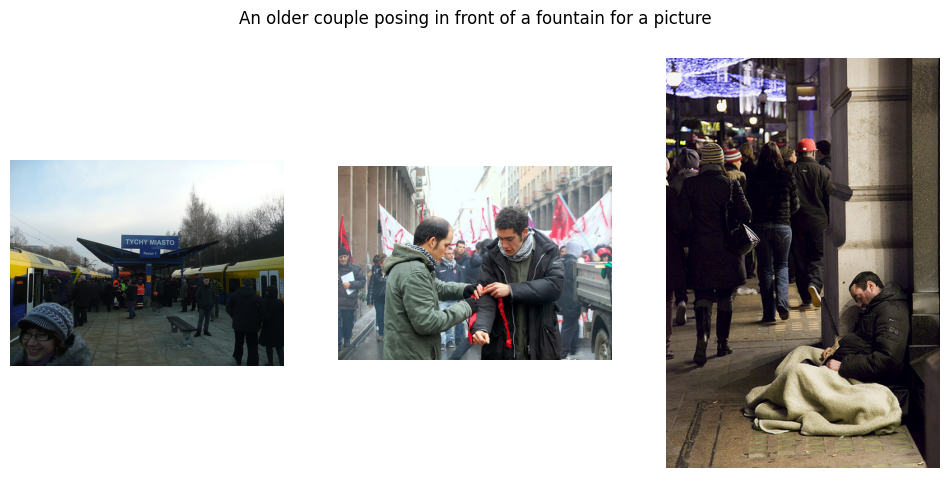

In [78]:
predict_LR(33)

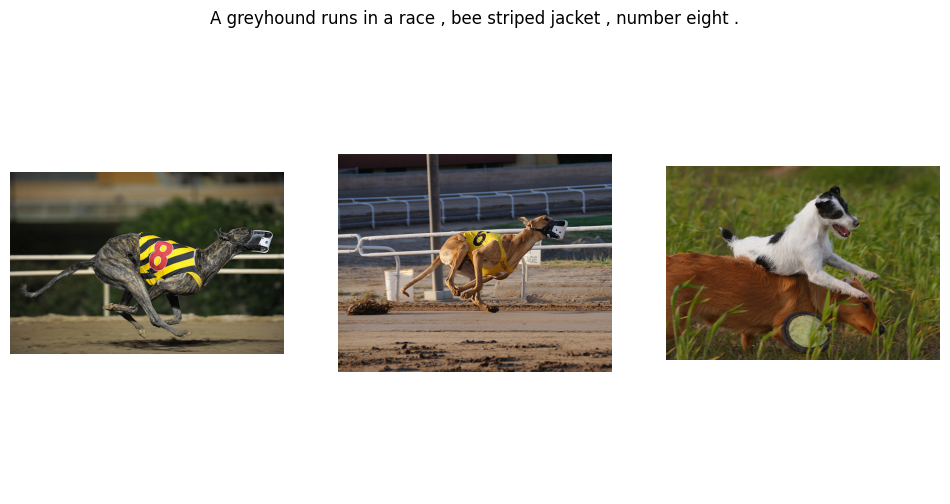

In [79]:
predict_LR(132)

#### Вывод

Случайные выборки из валидационной выборки показывают, что линейная регрессия в целом справляется с работой: она не попадает в детали (рыжая собака, хотя в запросе чёрная), но в целом не промахивается совсем уж сильно.

### Нейронная сеть

Теперь обучим сравнительно простую нейросеть.

Нейросеть не принимает на вход трёхмерные тензоры с элементами типа float64, так что преобразуем входные и выходные вектора в двумерные тензоры float32

In [80]:
X_nn = tf.cast(tf.reshape(X, (X.shape[0], X.shape[2])), dtype=np.float32)
Y_nn = tf.cast(tf.reshape(Y, (Y.shape[0], Y.shape[2])), dtype=np.float32)

Кроме того, у нас есть возможность использовать валидацию на этапе обучения нейросети, подготовим данные

In [81]:
X_nn_val = tf.stack(X_test["query_vector"])
Y_nn_val = tf.stack(y_test["image_vector"])
X_nn_val = tf.cast(
    tf.reshape(X_nn_val, (X_nn_val.shape[0], X_nn_val.shape[2])), dtype=np.float32
)
Y_nn_val = tf.cast(
    tf.reshape(Y_nn_val, (Y_nn_val.shape[0], Y_nn_val.shape[2])), dtype=np.float32
)

In [82]:
def create_nn_model(
    dout=0.5, text_vector_size=text_vector_size, image_vector_size=image_vector_size
):
    scheduler = ExponentialDecay(
        initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.96
    )
    optimizer = Adam(learning_rate=scheduler)
    model = Sequential()
    model.add(
        Dense(text_vector_size, activation="relu")  # input_shape=(text_vector_size,),
    )
    if dout > 0:
        model.add(Dropout(dout))
    model.add(Dense(text_vector_size // 2, activation="relu"))
    if dout > 0:
        model.add(Dropout(dout))
    model.add(Dense(text_vector_size // 4, activation="relu"))
    model.add(Dense(image_vector_size, activation="relu"))
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=["mse"]
    )

    return model

In [83]:
nn_model = create_nn_model()

In [84]:
history = nn_model.fit(
    tf.cast(X, dtype=np.float32),
    tf.cast(Y, dtype=np.float32),
    batch_size=100,
    epochs=100,
    validation_data=(X_nn_val, Y_nn_val),
)

Epoch 1/100
5/5 [==============================] - 1s 63ms/step - loss: 1.0404 - mse: 1.0404 - val_loss: 1.0402 - val_mse: 1.0402
Epoch 2/100
5/5 [==============================] - 0s 31ms/step - loss: 1.0362 - mse: 1.0362 - val_loss: 1.0353 - val_mse: 1.0353
Epoch 3/100
5/5 [==============================] - 0s 30ms/step - loss: 1.0291 - mse: 1.0291 - val_loss: 1.0262 - val_mse: 1.0262
Epoch 4/100
5/5 [==============================] - 0s 30ms/step - loss: 1.0166 - mse: 1.0166 - val_loss: 1.0101 - val_mse: 1.0101
Epoch 5/100
5/5 [==============================] - 0s 30ms/step - loss: 0.9960 - mse: 0.9960 - val_loss: 0.9829 - val_mse: 0.9829
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 0.9628 - mse: 0.9628 - val_loss: 0.9398 - val_mse: 0.9398
Epoch 7/100
5/5 [==============================] - 0s 31ms/step - loss: 0.9130 - mse: 0.9130 - val_loss: 0.8792 - val_mse: 0.8792
Epoch 8/100
5/5 [==============================] - 0s 31ms/step - loss: 0.8487 - mse: 0.84

Видно, что по мере приблежения к 100 эпохе скорость обучения снижается. В итоге мы получаем на валибационной выборке значение MSE близкое к линрегу: 0.65

In [85]:
def find_image_NN(query_vector, ivecs, lim=3):
    """ищем в заданной серии ivecs lim векторов, наиболее близких к запросу query_vector. Функция возвращает имена файлов"""
    iv = nn_model.predict(query_vector)
    df = pd.DataFrame(ivecs)
    for i in df.index:
        df.loc[i, "dist"] = vec_distance(iv, df.loc[i, "image_vector"])
    return df.sort_values(by="dist")["image"].unique()[:lim]


def predict_NN(idx, df=y_test):
    """соберём для удобства предыдущие функции в одну, которая принимает индекс в валидационной выборке, извлекает из неё запрос, его вектор, строит прогноз и выводит результат"""
    qv = X_test.loc[idx, "query_vector"]
    qt = test_df[test_df["annotation_id"] == X_test.loc[idx, "annotation_id"]][
        "query_text"
    ].iloc[0]
    images = find_image_NN(qv, df)
    show_images(qt, images)

1/1 [==============================] - 0s 72ms/step


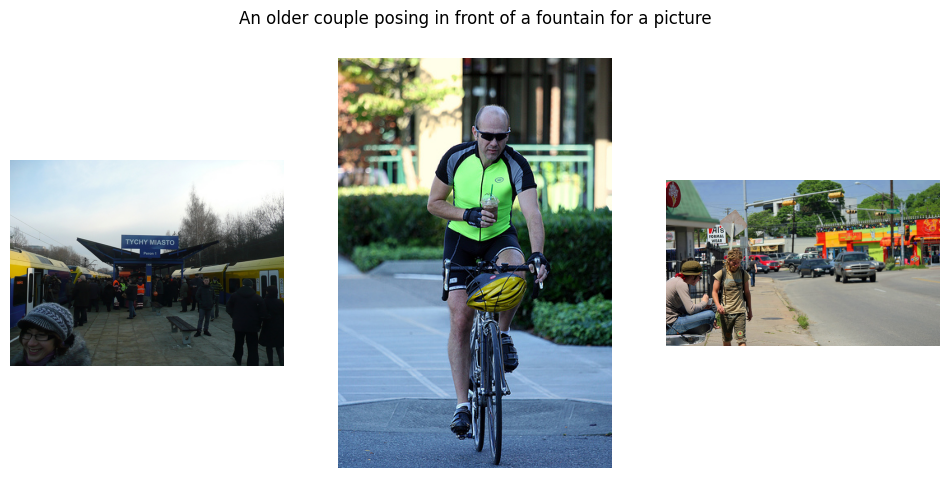

In [86]:
predict_NN(33)

1/1 [==============================] - 0s 20ms/step


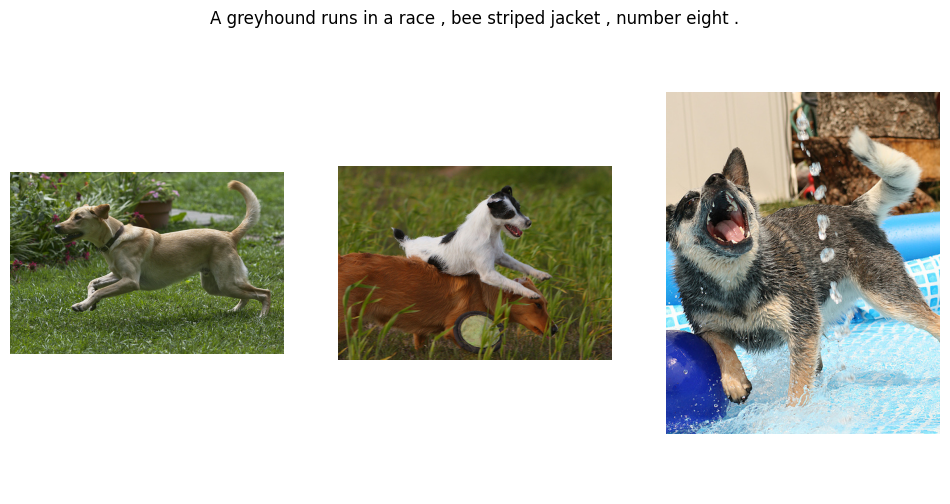

In [87]:
predict_NN(132)

#### Вывод

Судя по выборочным результатам обе модели дают очень близкие прогнозы. Ряд изображений, рекомендованных обеими моделями совпали.

Первое впечатление: предсказательная сила обеих моделей сопоставима, но нейросеть обучается на удивление быстрее регрессии.

### Проверка моделей на тестовой выборке

Заключительный этам - тестирование моделей на совершенно новых данных из тестовой выборки. Посмотрим, как они себя покажут.

Прежде всего, подготовим вектора тестовых изображений и запросов.

In [88]:
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [89]:
%%time
test_images["image_vector"] = test_images.apply(
    lambda x: tf.cast(model(image_to_array(x["image"], test_path)), dtype=np.float64),
    axis=1,
)

CPU times: user 58.7 s, sys: 2.46 s, total: 1min 1s
Wall time: 16.3 s


In [90]:
%%time
test_queries["lemm_query"] = test_queries["query_text"].apply(
    lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]
    )
)

CPU times: user 443 ms, sys: 38.3 ms, total: 481 ms
Wall time: 579 ms


In [91]:
tf_matrix = tfvect.transform(test_queries["lemm_query"])
test_queries["query_vector"] = tf_matrix.todense().tolist()

In [92]:
test_queries["lemm_query"][0]

'Two blonde boy , one in a camouflage shirt and the other in blue , be have a water fight .'

In [93]:
test_queries["query_vector"] = test_queries["query_vector"].apply(
    lambda x: tf.reshape(
        tf.convert_to_tensor(x, dtype=np.float64),
        (1, text_vector_size),
    )
)

In [94]:
tf_matrix = tfvect.transform(test_queries["lemm_query"])
test_queries["query_vector"] = tf_matrix.todense().tolist()

Нам нужны тензоры разного формата для регрессии и нейросети

In [97]:
test_queries["query_vector_32"] = test_queries.apply(
    lambda x: tf.reshape(
        tf.convert_to_tensor(x["query_vector"], dtype=np.float32), (1, text_vector_size)
    ),
    axis=1,
)

In [98]:
test_queries["query_vector_64"] = test_queries.apply(
    lambda x: tf.reshape(
        tf.convert_to_tensor(x["query_vector"], dtype=np.float64), (1, text_vector_size)
    ),
    axis=1,
)

In [100]:
def pred_lr_test(idx, ivecs=test_images, lim=3):
    if len(set(test_queries.loc[idx, "lemm_query"].split()) & set(child_stop)) > 0:
        print("Wrong query")
        return
    query = test_queries.loc[idx, "query_text"]
    vec = y_pred(test_queries.loc[idx, "query_vector_64"])

    df = pd.DataFrame(ivecs)
    for i in df.index:
        df.loc[i, "dist"] = vec_distance(vec, df.loc[i, "image_vector"])
    images = df.sort_values(by="dist")["image"].unique()[:lim]
    show_images(query, images, test_path)

Какая-то ерунда возникла над изображениями. Непонятно откуда она и как от неё избавиться. Тем более странно, что функция отображения - таже, что и использованная ранее. 

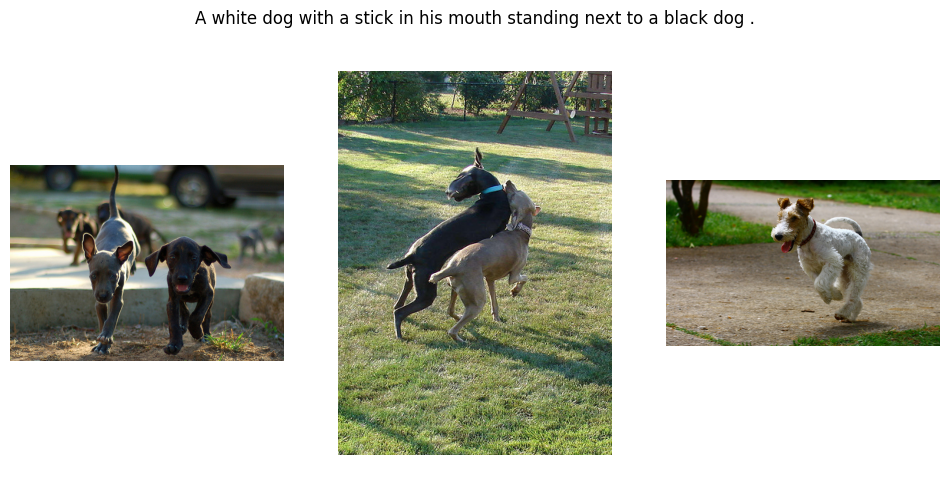

In [102]:
pred_lr_test(22)

In [103]:
def pred_nn_test(idx, ivecs=test_images, lim=3):
    if len(set(test_queries.loc[idx, "lemm_query"].split()) & set(child_stop)) > 0:
        print("Wrong query")
        return
    query = test_queries.loc[idx, "query_text"]
    vec = nn_model.predict(test_queries.loc[idx, "query_vector_64"])

    df = pd.DataFrame(ivecs)
    for i in df.index:
        df.loc[i, "dist"] = vec_distance(vec, df.loc[i, "image_vector"])
    images = df.sort_values(by="dist")["image"].unique()[:lim]
    show_images(query, images, test_path)

1/1 [==============================] - 0s 34ms/step


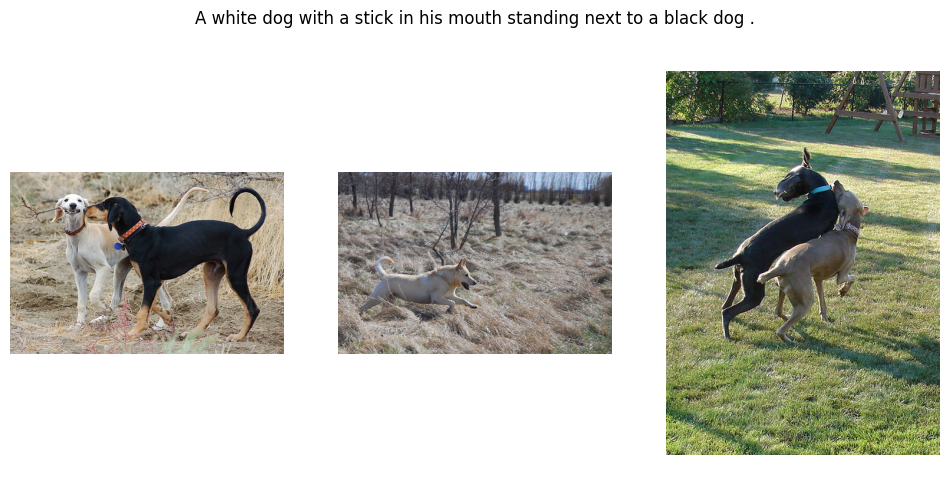

In [105]:
pred_nn_test(22)

Для удобства использования моделей в дальнейшем, сделаем функцию более высокого порядка, принимающую описание и требуемую модель

In [106]:
def about_children(text):
    """Если в лемматезированном описании присутствуют слова, описывающие детей, возвращаем True, иначе False"""
    return len(set(text.split()) & set(child_stop)) > 0


def prediction(query, model, ivecs):
    """функция принимает на вход текстовое описание и модель, которая предсказывает подходящее изображение"""
    if model == "linear_regression":
        func = y_pred
        dtype = np.float64
    elif model == "neural_network":
        func = nn_model.predict
        dtype = np.float32
    else:
        raise Exception(f"Wrong model: {model}")
    lemm = " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(query)]
    )
    if about_children(lemm):
        raise Exception(
            f"Wrong query '{query}'. Don't user queries about children please"
        )

    vec = func(tf.convert_to_tensor(tfvect.transform([lemm]).todense(), dtype=dtype))

    df = pd.DataFrame(ivecs)
    for i in df.index:
        df.loc[i, "dist"] = vec_distance(vec, df.loc[i, "image_vector"])
    images = df.sort_values(by="dist")["image"].unique()[:3]
    show_images(query, images, test_path)

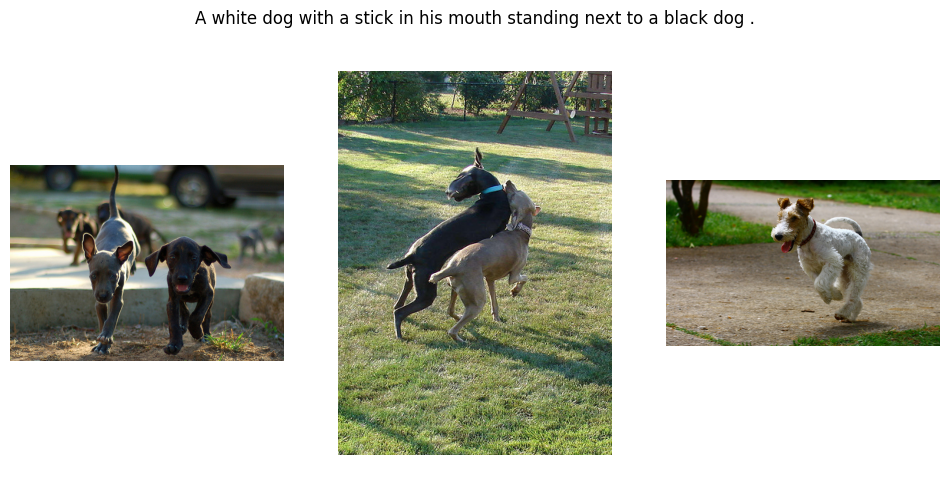

In [107]:
try:
    prediction(test_queries["query_text"][22], "linear_regression", test_images)
except Exception as e:
    print(e)
    count += 1

In [108]:
try:
    prediction(test_queries["query_text"][28], "linear_regression", test_images)
except Exception as e:
    print(e)
    count += 1

Wrong query 'Two young girls on a playground .'. Don't user queries about children please


In [ ]:
count = 5
for i in range(test_queries.shape[0]):
    count -= 1
    try:
        prediction(
            f"{i} " + test_queries["query_text"][i], "linear_regression", test_images
        )
    except Exception as e:
        print(e)
        count += 1
    if count == 0:
        break

## Выводы

Обе модели показали себя опять очень сходно в смысле прогнозов изображений, но попадания на тестовой выборке не очень хороши.

В целом концепция показала свою жизнеспособность, но она нуждается в существенной доработке. Возможные направления:
1. Увеличение датасета может существенно улучшить результаты
1. Использование более глубокой нейросети с более тщательным подбором гирперпараметров может положительно сказаться
1. Оценки комьюнити не выглядят очень точными и ценными, но они многочислены. Можно подумать, как их заставить работать на повышение точности моделей 